Need to go to the runtime tab, then change runtime and click the drop down menu on hardware accelerator and select GPU. With Google Colab Pro also change Runtime shape to High-RAM.

In [ ]:
# Install libraries needed using pip
!pip install transformers
!pip install wget

     |████████████████████████████████| 2.3MB 14.3MB/s 
     |████████████████████████████████| 901kB 46.0MB/s 
     |████████████████████████████████| 3.3MB 41.5MB/s 
  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=0a05248ebe525cb7c3ce12ac9b7453ee257fc38a2ef12c8e98a6fa81dfcc0d4e
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [ ]:
# Import libraries needed
import torch
import wget
import os
import pandas as pd
import numpy as np
from transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import time
import datetime
import random
import plotly.express as px
from sklearn.metrics import precision_score, recall_score, matthews_corrcoef, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sn
import itertools
print("All libraries imported.")

All libraries imported.


In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There is %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There is 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


In [ ]:
#This code block downloads all of the needed project data sets.
print('Downloading dataset')
# The URL for the dataset zip file.
#The Data sets are installed from a .zip file in a GitHub repo
url = 'https://github.com/jb17017/individual_project/blob/main/Datasets.zip?raw=true'
# Download the file (if we haven't already)
if not os.path.exists('./Datasets.zip'):
    wget.download(url, './Datasets.zip')

In [ ]:
# Unzip the dataset (if we haven't already)
if not os.path.exists('./Datasets/'):
    !unzip Datasets.zip

Archive:  Datasets.zip
  inflating: Datasets/dota2_combined_player_and_none_combined_training_set.csv  
  inflating: Datasets/dota2_olid_combined_training_set.csv  
  inflating: Datasets/dota2_test_set.csv  
  inflating: Datasets/dota2_training_set.csv  
  inflating: Datasets/labels-levela.csv  
  inflating: Datasets/olid-training-v1.0.tsv  
  inflating: Datasets/testset-levela.tsv  


In [ ]:
# Load the dataset into a pandas dataframe.

def train_data_unpacker():
  #Dota 2 training set 
  dota_training_set = pd.read_csv("./Datasets/dota2_training_set.csv", header=None, names=['index', 'local match index', 'text','label'])

  dota_train_sentences = dota_training_set.text.values
  dota_train_labels = dota_training_set.label.values

  #Converts the string labels to numbers so they can be used in the binary classifier
  dota_train_labels_num = label_to_number(dota_train_labels)

  print('Number of dota 2 training sentences: {:,}\n'.format(dota_training_set.shape[0]))

  #Dota 2 training set with player messages combined
  dota_training_player_combined_set = pd.read_csv("./Datasets/dota2_combined_player_and_none_combined_training_set.csv", header=None, names=['index', 'text','label'])

  dota_train_p_combined_sentences = dota_training_player_combined_set.text.values
  dota_train_p_combined_labels = dota_training_player_combined_set.label.values

  #Converts the string labels to numbers so they can be used in the binary classifier
  dota_train_p_combined_labels_num = label_to_number(dota_train_p_combined_labels)

  print('Number of dota 2 training sentences after concurrent player messages are combined and added to the dota 2 training set: {:,}\n'.format(dota_train_p_combined_sentences.shape[0]))

  #OLID training set
  olid_training_set = pd.read_csv("./Datasets/olid-training-v1.0.tsv", delimiter='\t', header=None, names=['id', 'tweet', 'subtask_a', 'subtask_b','subtask_c'])

  olid_train_sentences = olid_training_set.tweet.values
  olid_train_labels = olid_training_set.subtask_a.values

  #Converts the string labels to numbers so they can be used in the binary classifier
  olid_train_labels_num = label_to_number(olid_train_labels)

  print('Number of OLID training sentences: {:,}\n'.format(olid_train_sentences.shape[0]))

  #OLID and Dota 2 training sets combined
  dota2_olid_combined_training_set = pd.read_csv("./Datasets/dota2_olid_combined_training_set.csv", header=None, names=['id', 'tweet', 'subtask_a'])

  dota_and_olid_train_sentences = dota2_olid_combined_training_set.tweet.values
  dota_and_olid_train_labels = dota2_olid_combined_training_set.subtask_a.values

  #Converts the string labels to numbers so they can be used in the binary classifier
  dota_and_olid_train_labels_num = label_to_number(dota_and_olid_train_labels)

  print('Number of Dota 2 and OLID training sentences: {:,}\n'.format(dota_and_olid_train_sentences.shape[0]))

  return dota_train_sentences, dota_train_labels_num, dota_train_p_combined_sentences, dota_train_p_combined_labels_num, olid_train_sentences, olid_train_labels_num, dota_and_olid_train_sentences, dota_and_olid_train_labels_num

def test_data_unpacker():
  #Dota 2 test set
  dota_test_set = pd.read_csv("./Datasets/dota2_test_set.csv", header=None, names=['index', 'local match index', 'text','label'])

  dota_test_sentences = dota_test_set.text.values
  dota_test_labels = dota_test_set.label.values

  #Converts the string labels to numbers so they can be used in the binary classifier
  dota_test_labels_num = label_to_number(dota_test_labels)

  print('Number of dota 2 test sentences: {:,}\n'.format(dota_test_sentences.shape[0]))

  #OLID test set tweets and labels
  olid_test_tweets = pd.read_csv("./Datasets/testset-levela.tsv", delimiter='\t', header=None, names=['id', 'tweet'])
  olid_test_labels = pd.read_csv("./Datasets/labels-levela.csv", header=None, names=['id', 'subtask_a'])

  olid_test_sentences = olid_test_tweets.tweet.values
  olid_test_labels = olid_test_labels.subtask_a.values

  #Converts the string labels to numbers so they can be used in the binary classifier
  olid_test_labels_num = label_to_number(olid_test_labels)

  print('Number of OLID test sentences: {:,}\n'.format(olid_test_sentences.shape[0]))

  return dota_test_sentences, dota_test_labels_num, olid_test_sentences, olid_test_labels_num

In [ ]:
# Function that converts labels to numerical values
def label_to_number(labels):

  # This stores the labels as numerical values so they can be used in machine learning models
  num_labels = np.zeros(len(labels),dtype=int)

  # All OFF labels are changed to 1 and NOT remain 0
  for i in range(0,len(labels)):
    if (labels[i] == "OFF"):
      num_labels[i] = int(1)
  return num_labels

In [ ]:
# Defines a function used to tokenize the data set
def tokenize(sentences,tokenizer):
  input_ids = []
  # For every sentence...
  for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

  # Print sentence 0, now as a list of IDs.
  print('Original: ', sentences[0])
  print('Token IDs:', input_ids[0])
  return input_ids

In [ ]:
# Defines a function that returns the max sentence length for any data set
def max_length(input_ids):
  max_token_length = max([len(sen) for sen in input_ids])
  print('Max sentence length: ', max_token_length)
  return max_token_length

In [ ]:
# Defines a function that pads all the token text to the padded_length
def padding_data(padded_length, input_ids):

  # Padding length is chosen to be slightly larger than the maximum sentence length
  print('\nPadding/truncating all sentences to %d values...' % padded_length)

  # Pad our input tokens with value 0.
  # "post" indicates that we want to pad and truncate at the end of the sequence,
  # as opposed to the beginning.
  input_ids = pad_sequences(input_ids, maxlen=padded_length, dtype="long", 
                          value=0, truncating="post", padding="post")
  print('\Done.')
  return input_ids

In [ ]:
# Defines a function that creates attention masks for the tokenized sentences
def create_attention_masks(input_ids):

  # Initialise attention masks
  attention_masks = []


# For each sentence...
  for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

  return attention_masks

In [ ]:
# Defines a function that splits the data set into a training set and a validation set for accuracy measures during fine tuning.
def train_validation_split_func(input_ids, num_labels, attention_masks):

  # Use 90% for training and 10% for validation.

  train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, num_labels, 
                                                            random_state=2018, test_size=0.1)
  # Do the same for the masks.
  train_masks, validation_masks, _, _ = train_test_split(attention_masks, num_labels,
                                             random_state=2018, test_size=0.1)
  
  return train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks

In [ ]:
 # Function to convert inputs into torch tensors
def tensor_conversion(input):
  # Note not for labels as they require the data type to be torch.long
  input = torch.tensor(input)
  return input

# Function for converting labels to tensors
def tensor_conversion_labels(input_labels):
  # Note labels require the data type to be torch.long
  input_labels = torch.tensor(input_labels,dtype=torch.long)
  return input_labels

In [ ]:
 # Function that create the DataLoader for a training set.
def create_dataloader_train(train_inputs, train_masks, train_labels, validation_inputs, validation_masks, validation_labels, batch_size):
 
  # Create the DataLoader for a training set
  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
  
  # Create the DataLoader for our validation set.
  validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
  validation_sampler = SequentialSampler(validation_data)
  validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

  return train_dataloader, validation_dataloader
# Function that create the DataLoader for a test set.
def create_dataloader_test(test_inputs, test_masks, test_labels, batch_size):
  # Create the DataLoader for our test set.
  test_data = TensorDataset(test_inputs, test_masks, test_labels)
  test_sampler = SequentialSampler(test_data)
  test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

  return test_dataloader

In [ ]:
# Function that creates a BERT model, can specify which one
def model_creation_bert(model_string):
  # Load BertForSequenceClassification, the pretrained BERT model with a single 
  # linear classification layer on top. 
  model = BertForSequenceClassification.from_pretrained(
    model_string, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.  
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
  )

  # Get all of the model's parameters as a list of tuples.
  params = list(model.named_parameters())
  print('The BERT model has {:} different named parameters.\n'.format(len(params)))
  print('==== Embedding Layer ====\n')
  for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
  print('\n==== First Transformer ====\n')
  for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
  print('\n==== Output Layer ====\n')
  for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

  return model

In [ ]:
# Function that creates the optimizer object
def optimizer_func(model, train_dataloader):
  #Uses the Adam optimizer with Weight decay fix
  optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # learning_rate 
                  eps = 1e-8 # adam_epsilon 
                )
  # Toggle for between commenting and uncommenting for 4 or 6, 4 is default
  # epochs = 6
  epochs = 4
  # Total number of training steps is number of batches * number of epochs.
  total_steps = len(train_dataloader) * epochs
  # Create the learning rate scheduler.
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # We do not want to warm up as want to start learning with maximum rate
                                            num_training_steps = total_steps)
  return optimizer, epochs, total_steps, scheduler

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    # Changes logits to binary labels
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# Function that formats time, making it easier to read
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# Function that trains and validates the model
def train_model(model,seed_val,epochs,optimizer,scheduler,train_dataloader,validation_dataloader):
  # This training code is based on the `run_glue.py` script here:
  # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
  # Initialise random seed everywhere
  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)
  # Store the average loss after each epoch so we can plot them.
  loss_values = []
  # For each epoch...
  for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_loss = 0
    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        
        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
        # Track the number of batches
        nb_eval_steps += 1
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

  print("")
  print("Training complete!")
  return loss_values

In [ ]:
# Function that plots a loss graph of training epochs vs the average loss after each epoch
def loss_graph(loss_values):
  f = pd.DataFrame(loss_values)
  f.columns=['Loss']
  fig = px.line(f, x=(f.index+1), y=f.Loss)
  fig.update_layout(xaxis_title='Epoch',
                   yaxis_title='Loss',
                    font=dict(size=18))
  fig.show()

In [ ]:
# Function that predicts the labels with the trained model
def prediction_model(model, prediction_dataloader, prediction_inputs):
  # Prediction on test set
  print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))
  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  predictions , true_labels = [], []
  # Predict 
  for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
    logits = outputs[0]
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
  print('DONE.')
  return predictions, true_labels

In [ ]:
# Function that returns number of offensive messages in a data set
def positive_samples(labels):
  print('Positive samples: %d of %d (%.2f%%)' % (labels.sum(), len(labels), (labels.sum() / len(labels) * 100.0)))

In [ ]:
# Function that flattens the logits from prediction into binary labels
def flatten_labels(true_labels, prediction_labels):
  # Combine the predictions for each batch into a single list of 0s and 1s.
  flat_predictions = [item for sublist in prediction_labels for item in sublist]
  flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
  
  # Combine the correct labels for each batch into a single list.
  flat_true_labels = [item for sublist in true_labels for item in sublist]
  
  return flat_true_labels, flat_predictions

In [ ]:
# Function that returns the binary precision and recall scores
def precision_recall(flat_true_labels,flat_predictions):
  prec_bin = precision_score(flat_true_labels, flat_predictions)
  print("precision binary score: %.3f"%prec_bin)
  reca_bin = recall_score(flat_true_labels, flat_predictions)
  print("recall binary score: %.3f"%reca_bin)


In [ ]:
# Function that calculates the F1 macro and binary scores
def calc_f1(flat_true_labels,flat_predictions):
  f1_macro = f1_score(flat_true_labels,flat_predictions,average='macro')
  f1_binary = f1_score(flat_true_labels,flat_predictions)
  print("F1 binary score: %.3f"%f1_binary)
  print("F1 macro score: %.3f"%f1_macro)
  return f1_binary

In [ ]:
# Function that calculates the MCC for a model
def calc_matt_corrcoef(flat_true_labels, flat_predictions):
  mcc = matthews_corrcoef(flat_true_labels, flat_predictions)
  print('MCC: %.3f' % mcc)
  return mcc

In [ ]:
# Function that plots a confusion matrix for a model
def plot_confusion_matrix(flat_true_labels,flat_predictions):
  cm = confusion_matrix(flat_true_labels,flat_predictions)
  plt.figure(figsize = (10,10))
  sn.heatmap(cm, annot=True,annot_kws={"size": 18},robust = True, fmt="d", cmap = plt.get_cmap('Greys'),xticklabels=["NOT","OFF"],yticklabels=["NOT","OFF"])
  sn.set(font_scale=1.6) # for label size
  plt.xlabel('predicted label',size=18)
  plt.ylabel('true label',size=18)
  plt.show()

In [ ]:
# Function that collects the TP, TN, FP and FN cases
def predict_cases(flat_true_labels, flat_predictions, sentences):
  tp = []
  tn = []
  fp = []
  fn = []

  for i in range(0, len(sentences)):
    # If this the either TP or TN
    if (flat_predictions[i] == flat_true_labels[i]):
      # Must be TN
      if (flat_predictions[i] == 0):
        tn.append((sentences[i],flat_predictions[i],flat_true_labels[i]))
      # Must be TP
      else:
        tp.append((sentences[i],flat_predictions[i],flat_true_labels[i]))
    # Either FP or FN
    else:
      # Must be FN
      if (flat_predictions[i] == 0):
        fn.append((sentences[i],flat_predictions[i],flat_true_labels[i]))
      # Must be FP
      else:
        fp.append((sentences[i],flat_predictions[i],flat_true_labels[i]))

  return tp, tn, fp, fn

# **The training and test data loaded in to arrays**

In [ ]:
#All training data
dota_train_sentences, dota_train_labels, dota_train_p_combined_sentences, dota_train_p_combined_labels, olid_train_sentences, olid_train_labels, dota_and_olid_train_sentences, dota_and_olid_train_labels = train_data_unpacker()

#All test data
dota_test_sentences, dota_test_labels, olid_test_sentences, olid_test_labels = test_data_unpacker()

Number of dota 2 training sentences: 14,913

Number of dota 2 training sentences after concurrent player messages are combined and added to the dota 2 training set: 17,612

Number of OLID training sentences: 13,240

Number of Dota 2 and OLID training sentences: 28,153

Number of dota 2 test sentences: 1,508

Number of OLID test sentences: 860



# **Train BERT with OLID**

In [ ]:
# Toggle comments for different tokenizers, use tokenizer for model intended to be used
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
#tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

#The input ids for OLID
olid_input_ids = tokenize(olid_train_sentences,tokenizer)

max_length(olid_input_ids)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

olid_padding_length = 184

# Padded OLID IDs
olid_input_ids = padding_data(olid_padding_length, olid_input_ids)

olid_train_attention_masks = create_attention_masks(olid_input_ids)

olid_train_inputs, olid_validation_inputs, olid_train_labels, olid_validation_labels, olid_train_masks, olid_validation_masks = train_validation_split_func(olid_input_ids, olid_train_labels, olid_train_attention_masks)

# Tensor conversions
olid_train_inputs = tensor_conversion(olid_train_inputs)
olid_validation_inputs = tensor_conversion(olid_validation_inputs)

olid_train_labels = tensor_conversion_labels(olid_train_labels)
olid_validation_labels = tensor_conversion_labels(olid_validation_labels)

olid_train_masks = tensor_conversion(olid_train_masks)
olid_validation_masks = tensor_conversion(olid_validation_masks)

# batch size specificed here, toggle comments to change it
batch_size = 32
#batch_size = 64
#batch_size = 16

#OLID train and validation DataLoaders
olid_train_dataloader, olid_validation_dataloader = create_dataloader_train(olid_train_inputs, olid_train_masks, olid_train_labels, olid_validation_inputs, olid_validation_masks, olid_validation_labels, batch_size)



Original:  @USER She should ask a few native Americans what their take on this is.
Token IDs: [101, 1030, 5310, 2016, 2323, 3198, 1037, 2261, 3128, 4841, 2054, 2037, 2202, 2006, 2023, 2003, 1012, 102]
Max sentence length:  171

Padding token: "[PAD]", ID: 0

Padding/truncating all sentences to 184 values...
\Done.


In [ ]:
# Initialise OLID model, toggle comments for model selection
olid_model = model_creation_bert("bert-base-uncased")
#olid_model = model_creation_bert("bert-large-uncased")

# Get the optimizer, hyper parameters and scheduler for OLID
olid_optimizer, olid_epochs, olid_total_steps, olid_scheduler = optimizer_func(olid_model,olid_train_dataloader)

# Tell pytorch to run this model on the GPU.
olid_model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
olid_seed_val = 20

#Trains the OLID model

olid_loss_values = train_model(olid_model, olid_seed_val, olid_epochs, olid_optimizer, olid_scheduler, olid_train_dataloader,olid_validation_dataloader)


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:13.
  Batch    80  of    373.    Elapsed: 0:00:25.
  Batch   120  of    373.    Elapsed: 0:00:37.
  Batch   160  of    373.    Elapsed: 0:00:50.
  Batch   200  of    373.    Elapsed: 0:01:02.
  Batch   240  of    373.    Elapsed: 0:01:15.
  Batch   280  of    373.    Elapsed: 0:01:27.
  Batch   320  of    373.    Elapsed: 0:01:40.
  Batch   360  of    373.    Elapsed: 0:01:52.

  Average training loss: 0.48
  Training epoch took: 0:01:56

Running Validation...
  Accuracy: 0.81
  Validation took: 0:00:04

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:12.
  Batch    80  of    373.    Elapsed: 0:00:25.
  Batch   120  of    373.    Elapsed: 0:00:37.
  Batch   160  of    373.    Elapsed: 0:00:50.
  Batch   200  of    373.    Elapsed: 0:01:02.
  Batch   240  of    373.    Elapsed: 0:01:15.
  Batch   280  of    373.    Elapsed: 0:01:27.
  Batch   320  of    373.    Elap

In [ ]:
# Plot loss graph for OLID
loss_graph(olid_loss_values)

# **Test BERT with OLID on OLID test set**

In [ ]:

# OLID test input IDs
olid_test_input_ids = tokenize(olid_test_sentences,tokenizer)

max_length(olid_test_input_ids)

# OLID test input IDs padded
olid_test_input_ids = padding_data(olid_padding_length,olid_test_input_ids)

olid_test_attention_masks = create_attention_masks(olid_test_input_ids)

# Convert to tensors.
olid_prediction_inputs = tensor_conversion(olid_test_input_ids)
olid_prediction_masks = tensor_conversion(olid_test_attention_masks)
olid_prediction_labels = tensor_conversion_labels(olid_test_labels)

# Prediction DataLoader for OLID test set

olid_prediction_dataloader = create_dataloader_test(olid_prediction_inputs, olid_prediction_masks, olid_prediction_labels, batch_size)


# Predict labels of OLID test set with the OLID model
olid_predictions, olid_true_labels = prediction_model(olid_model, olid_prediction_dataloader,olid_prediction_inputs)

positive_samples(olid_test_labels)

olid_flat_true_labels, olid_flat_predictions = flatten_labels(olid_true_labels, olid_predictions)

Original:  #WhoIsQ #WheresTheServer #DumpNike #DECLASFISA Democrats Support Antifa, Muslim Brotherhood, MS13, ISIS, Pedophilia, Child Trafficking, Taxpayer Funded Abortion’s, Election Fraud, Sedition And Treason!!! #LockThemAllUp #WWG1WGA #QAnon ⁦@USER URL
Token IDs: [101, 1001, 2040, 2483, 4160, 1001, 2073, 3367, 15689, 2121, 6299, 1001, 15653, 8238, 2063, 1001, 11703, 8523, 8873, 3736, 8037, 2490, 3424, 7011, 1010, 5152, 12865, 1010, 5796, 17134, 1010, 18301, 1010, 21877, 3527, 21850, 6632, 1010, 2775, 11626, 1010, 26980, 6787, 11324, 1521, 1055, 1010, 2602, 9861, 1010, 7367, 20562, 1998, 14712, 999, 999, 999, 1001, 5843, 10760, 9067, 7630, 2361, 1001, 1059, 27767, 2487, 27767, 2050, 1001, 1053, 6761, 2078, 1030, 5310, 24471, 2140, 102]
Max sentence length:  94

Padding/truncating all sentences to 184 values...
\Done.
Predicting labels for 860 test sentences...
DONE.
Positive samples: 240 of 860 (27.91%)


In [ ]:
#Performance metrics

# Calculate the MCC
olid_mcc = calc_matt_corrcoef(olid_flat_true_labels, olid_flat_predictions)

# Calculate the F1, binary and macro scores
olid_f1 = calc_f1(olid_flat_true_labels,olid_flat_predictions)

# Calculate the precisiona nd recall scores
precision_recall(olid_flat_true_labels,olid_flat_predictions)

MCC: 0.599
F1 binary score: 0.707
F1 macro score: 0.799
precision binary score: 0.732
recall binary score: 0.683


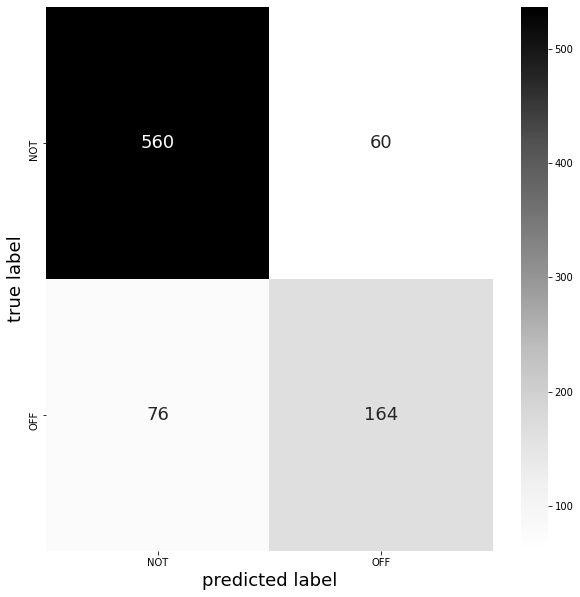

In [ ]:
# Plot confusion matrix of the OLID model's predictions on the OLID test set
plot_confusion_matrix(olid_flat_true_labels,olid_flat_predictions)

In [ ]:
# OLID TP, TN, FP, FN
olid_tp, olid_tn, olid_fp, olid_fn = predict_cases(olid_flat_true_labels,olid_flat_predictions, olid_test_sentences)

# **Test BERT with OLID on Dota 2 test set**

In [ ]:
#This is code to convert the dota test set to be used by the models

# Dota 2 test input IDs 
dota_test_input_ids = tokenize(dota_test_sentences,tokenizer)

max_length(dota_test_input_ids)

# Dota 2 test input IDs padded
dota_test_input_ids = padding_data(84,dota_test_input_ids)

dota_test_attention_masks = create_attention_masks(dota_test_input_ids)

# Convert to tensors.
dota_prediction_inputs = tensor_conversion(dota_test_input_ids)
dota_prediction_masks = tensor_conversion(dota_test_attention_masks)
dota_prediction_labels = tensor_conversion_labels(dota_test_labels)

# Dota 2 test set DataLoader
dota_prediction_dataloader = create_dataloader_test(dota_prediction_inputs, dota_prediction_masks, dota_prediction_labels, batch_size)

positive_samples(dota_test_labels)

Original:  gg
Token IDs: [101, 1043, 2290, 102]
Max sentence length:  29

Padding/truncating all sentences to 84 values...
\Done.
Positive samples: 254 of 1508 (16.84%)


In [ ]:
# Predict Dota 2 test set with OLID model
olid_on_dota_predictions, olid_on_dota_true_labels = prediction_model(olid_model, dota_prediction_dataloader,dota_prediction_inputs)

olid_on_dota_flat_true_labels, olid_on_dota_flat_predictions = flatten_labels(olid_on_dota_true_labels, olid_on_dota_predictions)


Predicting labels for 1,508 test sentences...
DONE.


In [ ]:
#Results...

# Calculate the MCC
dota_mcc = calc_matt_corrcoef(olid_on_dota_flat_true_labels, olid_on_dota_flat_predictions)

# Calculate the precision and recall scores
precision_recall(olid_on_dota_flat_true_labels,olid_on_dota_flat_predictions)

# Calculate the F1, binary and macro scores
olid_on_dota_f1 = calc_f1(olid_on_dota_flat_true_labels,olid_on_dota_flat_predictions)

MCC: 0.300
precision binary score: 0.556
recall binary score: 0.256
F1 binary score: 0.350
F1 macro score: 0.630


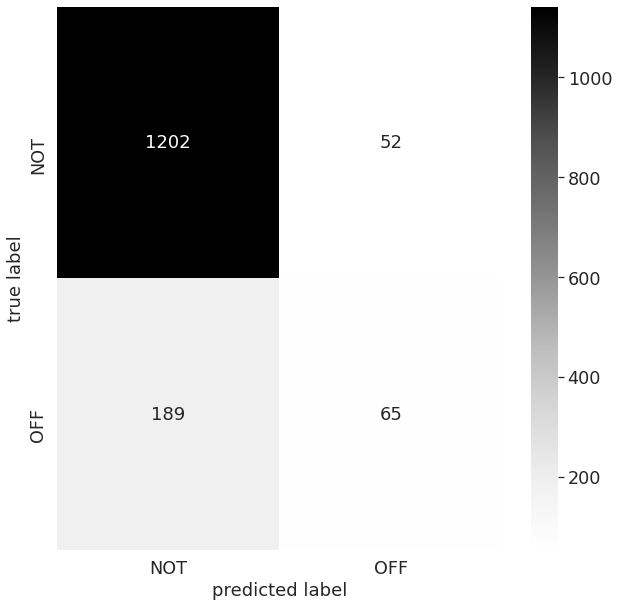

In [ ]:
# Plot confusion matrix for the Dota 2 set predicted by the OLID model
plot_confusion_matrix(olid_on_dota_flat_true_labels,olid_on_dota_flat_predictions)

In [ ]:
# TP, TN, FP and FN for Dota 2 test set predicted with OLID model
olid_dota_tp, olid_dota_tn, olid_dota_fp, olid_dota_fn = predict_cases(olid_on_dota_flat_true_labels,olid_on_dota_flat_predictions, dota_test_sentences)

tp_exp = pd.DataFrame(data = olid_dota_tp,columns=["message","predicted label","true label"])
tp_exp.to_csv('olid_dota2_tp.csv',index = False)

tn_exp = pd.DataFrame(data = olid_dota_tn,columns=["message","predicted label","true label"])
tn_exp.to_csv('olid_dota2_tn.csv',index = False)

fp_exp = pd.DataFrame(data = olid_dota_fp,columns=["message","predicted label","true label"])
fp_exp.to_csv('olid_dota2_fp.csv',index = False)

fn_exp = pd.DataFrame(data = olid_dota_fn,columns=["message","predicted label","true label"])
fn_exp.to_csv('olid_dota2_fn.csv',index = False)

# **Train BERT with Dota 2 training set**

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Dota 2 training set input IDs
dota_input_ids = tokenize(dota_train_sentences,tokenizer)

max_length(dota_input_ids)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Dota 2 training set input IDs padded
dota_input_ids = padding_data(84,dota_input_ids)

dota_attention_masks = create_attention_masks(dota_input_ids)

dota_train_inputs, dota_validation_inputs, dota_train_labels, dota_validation_labels, dota_train_masks, dota_validation_masks = train_validation_split_func(dota_input_ids, dota_train_labels, dota_attention_masks)

# Tensor conversion
dota_train_inputs = tensor_conversion(dota_train_inputs)
dota_validation_inputs = tensor_conversion(dota_validation_inputs)

dota_train_labels = tensor_conversion_labels(dota_train_labels)
dota_validation_labels = tensor_conversion_labels(dota_validation_labels)

dota_train_masks = tensor_conversion(dota_train_masks)
dota_validation_masks = tensor_conversion(dota_validation_masks)

# The DataLoader for Dota 2 training and validation

batch_size = 32
dota_train_dataloader, dota_validation_dataloader = create_dataloader_train(dota_train_inputs, dota_train_masks, dota_train_labels, dota_validation_inputs, dota_validation_masks, dota_validation_labels, batch_size)


Original:  why do people always play clinkz in turbo
Token IDs: [101, 2339, 2079, 2111, 2467, 2377, 18856, 19839, 2480, 1999, 15386, 102]
Max sentence length:  77

Padding token: "[PAD]", ID: 0

Padding/truncating all sentences to 84 values...
\Done.


In [ ]:
# Dota 2 model object
dota_model = model_creation_bert("bert-base-uncased")

# Dota 2 optimizer object, hyper paramaters and scheduler
dota_optimizer, dota_epochs, dota_total_steps, dota_scheduler = optimizer_func(dota_model,dota_train_dataloader)

# Tell pytorch to run this model on the GPU.
dota_model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
dota_seed_val = 42
# Trains the Dota 2 model
dota_loss_values = train_model(dota_model, dota_seed_val, dota_epochs, dota_optimizer, dota_scheduler, dota_train_dataloader, dota_validation_dataloader)


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    420.    Elapsed: 0:00:07.
  Batch    80  of    420.    Elapsed: 0:00:13.
  Batch   120  of    420.    Elapsed: 0:00:19.
  Batch   160  of    420.    Elapsed: 0:00:26.
  Batch   200  of    420.    Elapsed: 0:00:32.
  Batch   240  of    420.    Elapsed: 0:00:38.
  Batch   280  of    420.    Elapsed: 0:00:45.
  Batch   320  of    420.    Elapsed: 0:00:51.
  Batch   360  of    420.    Elapsed: 0:00:58.
  Batch   400  of    420.    Elapsed: 0:01:04.

  Average training loss: 0.19
  Training epoch took: 0:01:07

Running Validation...
  Accuracy: 0.95
  Validation took: 0:00:02

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    420.    Elapsed: 0:00:06.
  Batch    80  of    420.    Elapsed: 0:00:13.
  Batch   120  of    420.    Elapsed: 0:00:19.
  Batch   160  of    420.    Elapsed: 0:00:25.
  Batch   200  of    420.    Elapsed: 0:00:32.
  Batch   240  of    420.    Elapsed: 0:00:38.
  Batch   280  of    420.    Elap

In [ ]:
# Plots average loss graph
loss_graph(dota_loss_values)

# **Test BERT with Dota 2 on Dota 2 test set**

In [ ]:
# Predicts Dota 2 test set with Dota 2 model
dota_predictions, dota_true_labels = prediction_model(dota_model, dota_prediction_dataloader,dota_prediction_inputs)

positive_samples(dota_test_labels)

dota_flat_true_labels, dota_flat_predictions = flatten_labels(dota_true_labels, dota_predictions)


Predicting labels for 1,508 test sentences...
DONE.
Positive samples: 254 of 1508 (16.84%)


In [ ]:
# Calculate the MCC
dota_mcc = calc_matt_corrcoef(dota_flat_true_labels, dota_flat_predictions)

# Calculate the precision and recall
precision_recall(dota_flat_true_labels,dota_flat_predictions)

# Calculate the F1, binary and macro scores
dota_f1 = calc_f1(dota_flat_true_labels,dota_flat_predictions)

MCC: 0.863
precision binary score: 0.954
recall binary score: 0.819
F1 binary score: 0.881
F1 macro score: 0.930


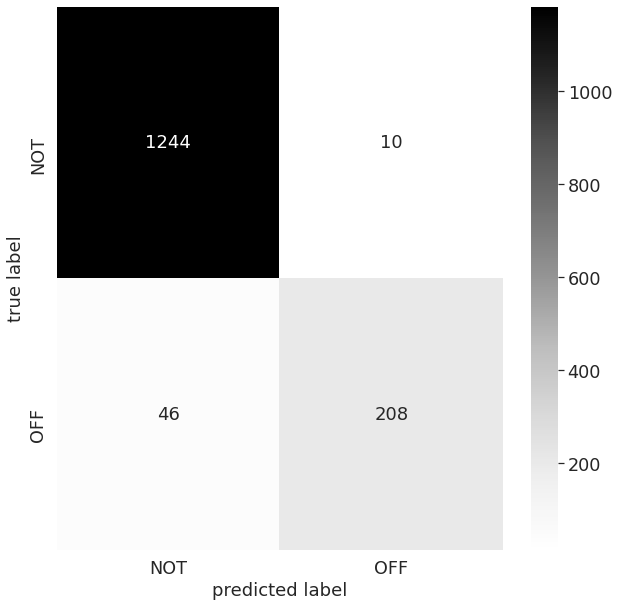

In [ ]:
# Plot confusion matrix for Dota 2 model
plot_confusion_matrix(dota_flat_true_labels,dota_flat_predictions)

In [ ]:
# TP, TN, FP, FN for Dota 2 model predicting Dota 2 test set
dota_tp, dota_tn, dota_fp, dota_fn = predict_cases(dota_flat_true_labels,dota_flat_predictions, dota_test_sentences)


# Exports above to files
dota_tp_exp = pd.DataFrame(data = dota_tp,columns=["message","predicted label","true label"])
dota_tp_exp.to_csv('dota2_tp.csv',index = False)

dota_tn_exp = pd.DataFrame(data = dota_tn,columns=["message","predicted label","true label"])
dota_tn_exp.to_csv('dota2_tn.csv',index = False)

dota_fp_exp = pd.DataFrame(data = dota_fp,columns=["message","predicted label","true label"])
dota_fp_exp.to_csv('dota2_fp.csv',index = False)

dota_fn_exp = pd.DataFrame(data = dota_fn,columns=["message","predicted label","true label"])
dota_fn_exp.to_csv('dota2_fn.csv',index = False)

# **Train BERT with OLID and Dota 2 model**

In [ ]:
# OLID and Dota 2 model 

dota_and_olid_train_input_ids = tokenize(dota_and_olid_train_sentences,tokenizer)

dota_and_olid_input_ids = padding_data(184,dota_and_olid_train_input_ids)

dota_and_olid_attention_masks = create_attention_masks(dota_and_olid_input_ids)

dota_and_olid_train_inputs, dota_and_olid_validation_inputs, dota_and_olid_train_labels, dota_and_olid_validation_labels, dota_and_olid_train_masks, dota_and_olid_validation_masks = train_validation_split_func(dota_and_olid_input_ids, dota_and_olid_train_labels, dota_and_olid_attention_masks)

dota_and_olid_train_inputs = tensor_conversion(dota_and_olid_train_inputs)
dota_and_olid_validation_inputs = tensor_conversion(dota_and_olid_validation_inputs)

dota_and_olid_train_labels = tensor_conversion_labels(dota_and_olid_train_labels)
dota_and_olid_validation_labels = tensor_conversion_labels(dota_and_olid_validation_labels)

dota_and_olid_train_masks = tensor_conversion(dota_and_olid_train_masks)
dota_and_olid_validation_masks = tensor_conversion(dota_and_olid_validation_masks)

batch_size = 32
# batch_size = 64
dota_and_olid_train_dataloader, dota_and_olid_validation_dataloader = create_dataloader_train(dota_and_olid_train_inputs, dota_and_olid_train_masks, dota_and_olid_train_labels, dota_and_olid_validation_inputs, dota_and_olid_validation_masks, dota_and_olid_validation_labels, batch_size)


Original:  @USER She should ask a few native Americans what their take on this is.
Token IDs: [101, 1030, 5310, 2016, 2323, 3198, 1037, 2261, 3128, 4841, 2054, 2037, 2202, 2006, 2023, 2003, 1012, 102]

Padding/truncating all sentences to 184 values...
\Done.


In [ ]:
# Model object for OLID and Dota 2 model
dota_and_olid_model = model_creation_bert("bert-base-uncased")

dota_and_olid_optimizer, dota_and_olid_epochs, dota_and_olid_total_steps, dota_and_olid_scheduler = optimizer_func(dota_and_olid_model,dota_and_olid_train_dataloader)
# Tell pytorch to run this model on the GPU.
dota_and_olid_model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
dota_and_olid_seed_val = 59
#Training phase of OLID and Dota 2 model
dota_and_olid_loss_values = train_model(dota_and_olid_model, dota_and_olid_seed_val, dota_and_olid_epochs, dota_and_olid_optimizer, dota_and_olid_scheduler, dota_and_olid_train_dataloader,dota_and_olid_validation_dataloader)


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    792.    Elapsed: 0:00:12.
  Batch    80  of    792.    Elapsed: 0:00:25.
  Batch   120  of    792.    Elapsed: 0:00:37.
  Batch   160  of    792.    Elapsed: 0:00:50.
  Batch   200  of    792.    Elapsed: 0:01:02.
  Batch   240  of    792.    Elapsed: 0:01:15.
  Batch   280  of    792.    Elapsed: 0:01:27.
  Batch   320  of    792.    Elapsed: 0:01:39.
  Batch   360  of    792.    Elapsed: 0:01:52.
  Batch   400  of    792.    Elapsed: 0:02:04.
  Batch   440  of    792.    Elapsed: 0:02:17.
  Batch   480  of    792.    Elapsed: 0:02:29.
  Batch   520  of    792.    Elapsed: 0:02:42.
  Batch   560  of    792.    Elapsed: 0:02:54.
  Batch   600  of    792.    Elapsed: 0:03:06.
  Batch   640  of    792.    Elapsed: 0:03:19.
  Batch   680  of    792.    Elapsed: 0:03:31.
  Batch   720  of    792.    Elapsed: 0:03:44.
  Batch   760  of    792.    Elapsed: 0:03:57.

  Average training loss: 0.31
  Training epoch took: 0:04:07

R

# **Test BERT with OLID and Dota 2 on Dota 2 test set**

In [ ]:
# Predictions for Dota 2 test set with OLID and Dota 2 model
dota_and_olid_predictions, dota_and_olid_true_labels = prediction_model(dota_and_olid_model, dota_prediction_dataloader,dota_prediction_inputs)

dota_and_olid_flat_true_labels, dota_and_olid_flat_predictions = flatten_labels(dota_and_olid_true_labels, dota_and_olid_predictions)


Predicting labels for 1,508 test sentences...
DONE.


In [ ]:
#Results...

# Calculate the MCC
dota_and_olid_mcc = calc_matt_corrcoef(dota_and_olid_flat_true_labels, dota_and_olid_flat_predictions)

# Calculate the precision and recall
precision_recall(dota_and_olid_flat_true_labels,dota_and_olid_flat_predictions)

# Calculate the F1 score, binary and macro
dota_and_olid_f1 = calc_f1(dota_and_olid_flat_true_labels,dota_and_olid_flat_predictions)

MCC: 0.856
precision binary score: 0.937
recall binary score: 0.823
F1 binary score: 0.876
F1 macro score: 0.927


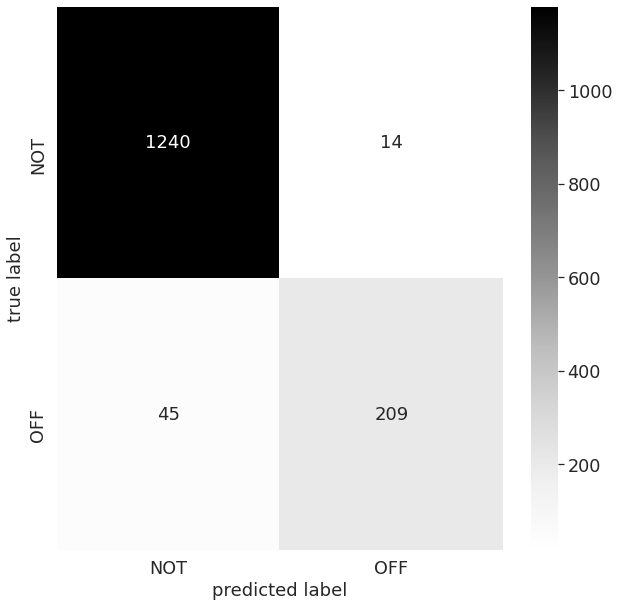

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(dota_and_olid_flat_true_labels,dota_and_olid_flat_predictions)

In [ ]:
# TP, TN, FP, FN for Dota 2 model predicting Dota 2 test set
dota_and_olid_tp, dota_and_olid_tn, dota_and_olid_fp, dota_and_olid_fn = predict_cases(dota_and_olid_flat_true_labels,dota_and_olid_flat_predictions, dota_test_sentences)

tp_exp = pd.DataFrame(data = dota_and_olid_tp,columns=["message","predicted label","true label"])
tp_exp.to_csv('dota_and_olid_tp.csv',index = False)

tn_exp = pd.DataFrame(data = dota_and_olid_tn,columns=["message","predicted label","true label"])
tn_exp.to_csv('dota_and_olid_tn.csv',index = False)

fp_exp = pd.DataFrame(data = dota_and_olid_fp,columns=["message","predicted label","true label"])
fp_exp.to_csv('dota_and_olid_fp.csv',index = False)

fn_exp = pd.DataFrame(data = dota_and_olid_fn,columns=["message","predicted label","true label"])
fn_exp.to_csv('dota_and_olid_fn.csv',index = False)

# **Train BERT with Dota 2 and player combined messages**

In [ ]:
# Dota 2 and player combined messages model

dota_p_combined_input_ids = tokenize(dota_train_p_combined_sentences,tokenizer)

dota_p_combined_input_ids = padding_data(84,dota_p_combined_input_ids)

dota_p_combined_attention_masks = create_attention_masks(dota_p_combined_input_ids)

dota_p_combined_train_inputs, dota_p_combined_validation_inputs, dota_p_combined_train_labels, dota_p_combined_validation_labels, dota_p_combined_train_masks, dota_p_combined_validation_masks = train_validation_split_func(dota_p_combined_input_ids, dota_train_p_combined_labels, dota_p_combined_attention_masks)

dota_p_combined_train_inputs = tensor_conversion(dota_p_combined_train_inputs)
dota_p_combined_validation_inputs = tensor_conversion(dota_p_combined_validation_inputs)

dota_p_combined_train_labels = tensor_conversion_labels(dota_p_combined_train_labels)
dota_p_combined_validation_labels = tensor_conversion_labels(dota_p_combined_validation_labels)

dota_p_combined_train_masks = tensor_conversion(dota_p_combined_train_masks)
dota_p_combined_validation_masks = tensor_conversion(dota_p_combined_validation_masks)

batch_size = 32

dota_p_combined_train_dataloader, dota_p_combined_validation_dataloader = create_dataloader_train(dota_p_combined_train_inputs, dota_p_combined_train_masks, dota_p_combined_train_labels, dota_p_combined_validation_inputs, dota_p_combined_validation_masks, dota_p_combined_validation_labels, batch_size)


Original:  why do people always play clinkz in turbo
Token IDs: [101, 2339, 2079, 2111, 2467, 2377, 18856, 19839, 2480, 1999, 15386, 102]

Padding/truncating all sentences to 84 values...
\Done.


In [ ]:
# Model object for Dota 2 and player combined messages model
dota_p_combined_model = model_creation_bert("bert-base-uncased")

dota_p_combined_optimizer, dota_p_combined_epochs, dota_p_combined_total_steps, dota_p_combined_scheduler = optimizer_func(dota_p_combined_model,dota_p_combined_train_dataloader)
# Tell pytorch to run this model on the GPU.
dota_p_combined_model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
dota_p_combined_seed_val = 59
#Training phase of Dota 2 and player combined messages model
dota_p_combined_loss_values = train_model(dota_p_combined_model, dota_p_combined_seed_val, dota_p_combined_epochs, dota_p_combined_optimizer, dota_p_combined_scheduler, dota_p_combined_train_dataloader,dota_p_combined_validation_dataloader)


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    496.    Elapsed: 0:00:07.
  Batch    80  of    496.    Elapsed: 0:00:13.
  Batch   120  of    496.    Elapsed: 0:00:19.
  Batch   160  of    496.    Elapsed: 0:00:26.
  Batch   200  of    496.    Elapsed: 0:00:32.
  Batch   240  of    496.    Elapsed: 0:00:39.
  Batch   280  of    496.    Elapsed: 0:00:45.
  Batch   320  of    496.    Elapsed: 0:00:52.
  Batch   360  of    496.    Elapsed: 0:00:58.
  Batch   400  of    496.    Elapsed: 0:01:05.
  Batch   440  of    496.    Elapsed: 0:01:11.
  Batch   480  of    496.    Elapsed: 0:01:18.

  Average training loss: 0.20
  Training epoch took: 0:01:20

Running Validation...
  Accuracy: 0.95
  Validation took: 0:00:03

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    496.    Elapsed: 0:00:06.
  Batch    80  of    496.    Elapsed: 0:00:13.
  Batch   120  of    496.    Elapsed: 0:00:19.
  Batch   160  of    496.    Elapsed: 0:00:26.
  Batch   200  of    496.    Elap

# **Test BERT with Dota 2 and player combined messages on Dota 2 test set**

In [ ]:
# Predictions for Dota 2 test set with OLID and Dota 2 model
dota_p_combined_predictions, dota_p_combined_true_labels = prediction_model(dota_p_combined_model, dota_prediction_dataloader,dota_prediction_inputs)

dota_p_combined_flat_true_labels, dota_p_combined_flat_predictions = flatten_labels(dota_p_combined_true_labels, dota_p_combined_predictions)


In [ ]:
#Results...

# Calculate the MCC
dota_p_combined_mcc = calc_matt_corrcoef(dota_p_combined_flat_true_labels, dota_p_combined_flat_predictions)

# Calculate the precision and recall
precision_recall(dota_p_combined_flat_true_labels,dota_p_combined_flat_predictions)

# Calculate the F1 score, binary and macro
dota_p_combined_f1 = calc_f1(dota_p_combined_flat_true_labels,dota_p_combined_flat_predictions)

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(dota_p_combined_flat_true_labels,dota_p_combined_flat_predictions)

In [ ]:
# TP, TN, FP, FN for Dota 2 model predicting Dota 2 test set
dota_p_combined_tp, dota_p_combined_tn, dota_p_combined_fp, dota_p_combined_fn = predict_cases(dota_p_combined_flat_true_labels,dota_p_combined_flat_predictions, dota_test_sentences)

tp_exp = pd.DataFrame(data = dota_p_combined_tp,columns=["message","predicted label","true label"])
tp_exp.to_csv('dota_p_combined_tp.csv',index = False)

tn_exp = pd.DataFrame(data = dota_p_combined_tn,columns=["message","predicted label","true label"])
tn_exp.to_csv('dota_p_combined_tn.csv',index = False)

fp_exp = pd.DataFrame(data = dota_p_combined_fp,columns=["message","predicted label","true label"])
fp_exp.to_csv('dota_p_combined_fp.csv',index = False)

fn_exp = pd.DataFrame(data = dota_p_combined_fn,columns=["message","predicted label","true label"])
fn_exp.to_csv('dota_p_combined_fn.csv',index = False)